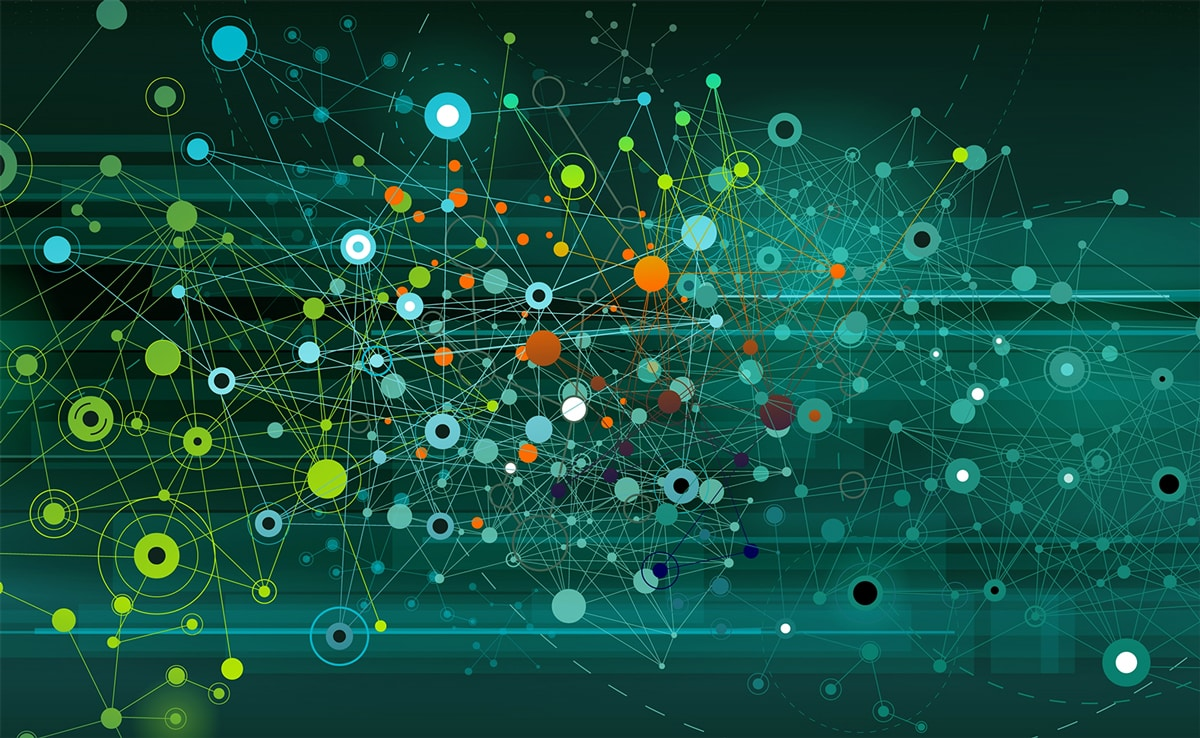
# Livrable 1

## Classification binaire

## Import

L'ensemble des imports des bibliothèques pour mener à bien ce projet.

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from PIL import Image
import configuration
import fidle.pwk as pwk
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report, confusion_matrix
import datetime
import pathlib
from tensorboard.plugins.hparams import api as hp
%matplotlib inline
from keras.utils.vis_utils import plot_model

## Datasets

In [2]:
image_h = 180
image_w = 180
batch_s = 32

data_dir = configuration.data_dir
train_set = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  labels = "inferred",
  validation_split= 0.8, 
  subset = "training",
  seed=42,
  batch_size=batch_s,
  image_size=(image_h, image_w),
)

# Le test_set
validation_set = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  labels = "inferred",
  validation_split= 0.2,
  subset = "validation",
  seed=42,
  batch_size=batch_s,
  image_size=(image_h, image_w),
)
class_names = train_set.class_names


Found 41405 files belonging to 2 classes.
Using 8281 files for training.
Found 41405 files belonging to 2 classes.
Using 8281 files for validation.


## Visualisation

Dans un second temps nous allons voir la répartion des dataset, en effet les dataset ne sont surement pas équilibré, pour cela nous allons utiliser un histogramme, cette histogramme vas nous permettre de mettre cela en évidence pour chaque classe.

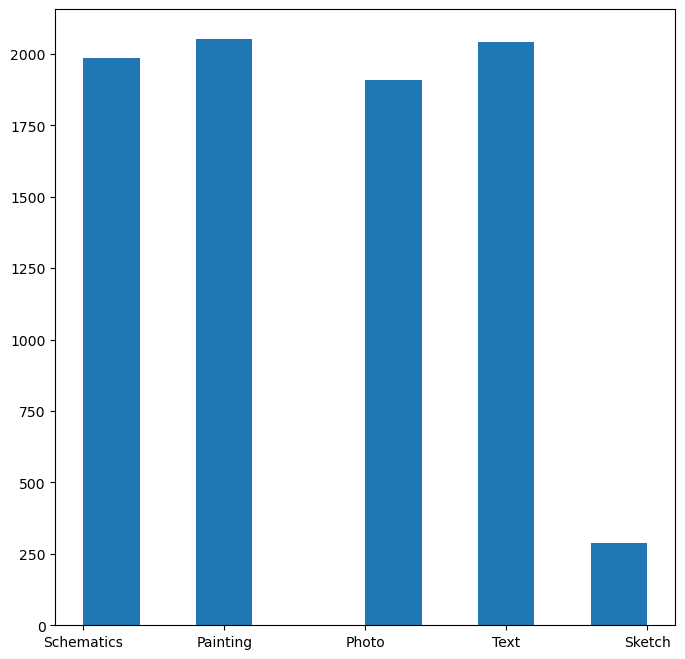




Par la suite nous avons aussi décider d'afficher différentes images de chaque classe, de façon à avoir une représentation de chaque classe.

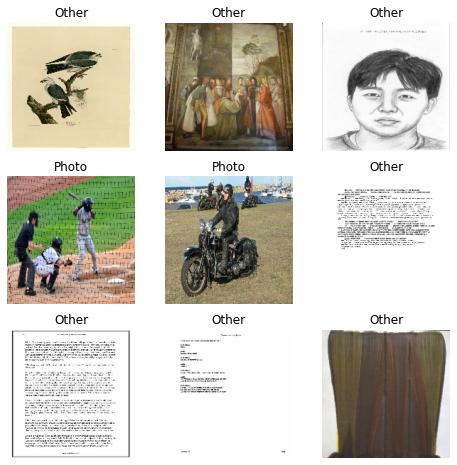

In [3]:
# Répartition des classes

label_list = []
i=0
plt.figure(figsize=(8, 8))

for images, labels in train_set.take(-1):
    i += 1
for label in labels.numpy():
    label_list.append(class_names[label])
for i in range(9):
    ax =  plt.subplot(3, 3, i + 1)
    plt.title(class_names[labels[i]])
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

plt.hist(label_list)
plt.show()

### Batch info

Le image_batch est un tenseur de la forme (256, 180, 180, 3) . Ceci est un lot de 256 images de forme 180x180x3 (la dernière dimension se réfère à des canaux de couleur RVB). 

Le label_batch est un tenseur de la forme (256,) , ceux - ci sont des étiquettes correspondant aux 256 images.

In [4]:
for image_batch, labels_batch in train_set:
   print(image_batch.shape)
   print(labels_batch.shape)
   break


(32, 180, 180, 3)
(32,)


## Mise en cache

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_set = validation_set.cache().prefetch(buffer_size=AUTOTUNE)

In [6]:
num_classes = len(class_names)
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                      input_shape=(image_h,
                                  image_w,
                                  3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1)
  ]
)

# Le modèle
model_single_layer = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(image_h, image_w, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(32, activation='relu'),
  layers.Dense(num_classes)
])
# Compilation du modèle
model_single_layer.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, histogram_freq=1)
hparams_callback = hp.KerasCallback(log_dir, {
    'num_relu_units': 16,
    'dropout': 0.2
})
# Résumé du modèle
model_single_layer.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 90, 90, 16)        0         
                                                                 
 flatten (Flatten)           (None, 129600)            0         
                                                      

### Checkpoint

Pour ne pas perdre du temps à ré entrainer les models à chaque fois nous réalisons des checkpoints nous permettant de conserver les valeurs de notre modèle le plus performant. 

In [7]:
# Prepare for model checkpoints
checkpoint_path = "training/cp_single_layer_{epoch:02d}-{val_accuracy:.2f}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor='val_accuracy',
                                                 save_best_only=True,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 mode='max')

### Entrainement du modèle

In [8]:
if not os.path.isfile('./training/simple_layer_model.5.h5'):
    epochs=3
    history = model_single_layer.fit(
      train_set,
      validation_data=validation_set,
      epochs=epochs,
      callbacks=[cp_callback]
    )

    # Save the model
    save_path = "checkpoints/"+datetime.datetime.now().strftime("%d-%m-%Y_%H-%M-%S")+"-"+str(history.history['val_accuracy'][-1])+".ckpt"
    model_single_layer.save_weights(save_path)
    model_single_layer.save_weights('./training/simple_layer_model.5.h5')

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()


## Construction du modèle 3 couche de convolution

In [9]:
num_classes = len(class_names)
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                      input_shape=(image_h,
                                  image_w,
                                  3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1)
  ]
)

# Le modèle
model_multiple_layers = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(image_h, image_w, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(32, activation='relu'),
  layers.Dense(num_classes)
])
# Compilation du modèle
model_multiple_layers.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, histogram_freq=1)
hparams_callback = hp.KerasCallback(log_dir, {
    'num_relu_units': 16,
    'dropout': 0.2
}
                                    
                                    )
# Résumé du modèle
model_multiple_layers.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

### Checkpoint

Pour ne pas perdre du temps à ré entrainer les models à chaque fois nous réalisons des checkpoints nous permettant de conserver les valeurs de notre modèle le plus performant. 

In [10]:
# Prepare for model checkpoints
checkpoint_path = "training/cp_multiple_layers_{epoch:02d}-{val_accuracy:.2f}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor='val_accuracy',
                                                 save_best_only=True,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 mode='max')

### Entrainement du modèle

In [ ]:
if not os.path.isfile('./training/mulitple_layer_model.5.h5'):
    # Entrainement du modèle
    epochs=5
    history = model_multiple_layers.fit(
      train_set,
      validation_data=validation_set,
      epochs=epochs,
      callbacks=[cp_callback]
    )

    # Save the model
    save_path = "checkpoints/"+datetime.datetime.now().strftime("%d-%m-%Y_%H-%M-%S")+"-"+str(history.history['val_accuracy'][-1])+".ckpt"
    model_multiple_layers.save_weights(save_path)
    model_multiple_layers.save_weights('./training/mulitple_layer_model.5.h5')

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

    

Epoch 1/5
259/259 [==============================] - ETA: 0s - loss: 0.3976 - accuracy: 0.7762
Epoch 00001: val_accuracy improved from -inf to 0.81560, saving model to training\cp_multiple_layers_01-0.82.ckpt
259/259 [==============================] - 497s 1s/step - loss: 0.3976 - accuracy: 0.7762 - val_loss: 0.3434 - val_accuracy: 0.8156
Epoch 2/5
259/259 [==============================] - ETA: 0s - loss: 0.3533 - accuracy: 0.8164
Epoch 00002: val_accuracy improved from 0.81560 to 0.82949, saving model to training\cp_multiple_layers_02-0.83.ckpt
259/259 [==============================] - 486s 2s/step - loss: 0.3533 - accuracy: 0.8164 - val_loss: 0.3339 - val_accuracy: 0.8295
Epoch 3/5
259/259 [==============================] - ETA: 0s - loss: 0.3261 - accuracy: 0.8396
Epoch 00003: val_accuracy improved from 0.82949 to 0.85267, saving model to training\cp_multiple_layers_03-0.85.ckpt
259/259 [==============================] - 513s 2s/step - loss: 0.3261 - accuracy: 0.8396 - val_loss: 0

In [ ]:
!tensorboard dev upload --logdir ./logs \
   --name "Attempt 2" \
   --description "Add 2 layer with convolution (32, 64) + max pooling" \
   --one_shot

## Validation

### Recupération du model

In [ ]:
model_multiple_layers.load_weights("./training/mulitple_layer_model.5.h5")

## Test de l'accuracy du model

In [ ]:
test_loss, test_acc = model_single_layer.evaluate(validation_set, verbose=2)

print('\nTest accuracy:', test_acc)

# y_sigmoid = model_multiple_layers.predict(validation_set)
# y_pred    = np.argmax(y_sigmoid, axis=-1)

### Matrice de confusion

In [ ]:
y_pred = []  # store predicted labels
y_true = []  # store true labels
list_image = []
list_pred = []

# iterate over the dataset
for image_batch, label_batch in validation_set:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model_multiple_layers.predict(image_batch)
   list_pred.append(preds)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))
   list_image.append(image_batch)

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

In [ ]:

print('Confusion Matrix')
print(confusion_matrix(correct_labels, predicted_labels))
pwk.plot_confusion_matrix(correct_labels,predicted_labels,range(2),normalize=True, save_as='06-confusion-matrix')

In [ ]:
print('Classification Report')

print(classification_report(correct_labels, predicted_labels, target_names=class_names))

## Exemple d'erreurs

In [ ]:
# file_paths = validation_set.file_paths


In [ ]:

batch_iterator = 0
for images, labels in validation_set.take(10, 'aa'):

    preds = model_multiple_layers.predict(images)
    preds = np.argmax(preds, axis = - 1)
    j = 0
    b = 0
    while j < 9 and b < batch_s:
        if preds[b] != labels[b].numpy():
            ax = plt.subplot(3, 3, j + 1)
            j += 1
            # print(validation_set.take(batch_iterator).file_paths[i])
            plt.imshow(images[b].numpy().astype("uint8"))
            plt.title(class_names[preds[b]] + " : " + class_names[labels[b].numpy()])
            plt.axis("off")
        b += 1
    batch_iterator += 1
plt.tight_layout()
plt.show()
#
# pwk.plot_images(list_image, y_true, errors[:15], columns=6, x_size=2, y_size=2, y_pred=y_pred, save_as='05-some-errors')

## Affichage Couche de neuronnes

In [ ]:
tf.keras.utils.plot_model(
model_multiple_layers, to_file='image/model_multiple.png', show_shapes=True, show_dtype=False,
show_layer_names=True, expand_nested=True, dpi=96
)
tf.keras.utils.plot_model(
model_single_layer, to_file='image/model_single.png', show_shapes=True, show_dtype=False,
show_layer_names=True, expand_nested=True, dpi=96
)

#plot_model(model_multiple_layers, to_file='image/model_multiple_layers.png', show_shapes=True)"
#plot_model(model_single_layers, to_file='image/model_single_layers.png', show_shapes=True)"